In [1]:
from PIL import Image
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import wandb
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZES = [100, 100]

In [3]:
# reads all images in filepath, resizes it according with 2D list img_sizes and 
# store them in a np_array. The string filepath can only contain images (no other
# file types such as txt for example are allowed). 
# It works only for RGB images.
def images_to_np_array(filepath, img_sizes):
    #-----------------------------------------------------------------------------
    # Args:
    #     filepath:  String with the path to the directory containing the images.
    #                It CANNOT end with the / character.
    #     img_sizes: 2D array [num_rows, num_columns].
    #-----------------------------------------------------------------------------

    # list all files in filepath
    list_of_files = [file for file in os.listdir(filepath)]

    # number of image files
    n_images = len(list_of_files)

    # create np_array to store all images
    array_images = np.zeros([n_images, IMAGE_SIZES[0], IMAGE_SIZES[1], 3])

    for index in range( n_images ):

        # get file name   
        file_name = list_of_files[index]

        # Open the image form working directory
        image = Image.open(filepath + '/' + file_name)

        # resize image
        image_resized = image.resize(IMAGE_SIZES)

        # convert it to numpy
        np_image = np.asarray(image_resized)
        array_images[index,:,:,:] = np_image

    return array_images



In [4]:
# Building training data

# read all capivaras
capivara_train = images_to_np_array(filepath = "./capivara_augmented", img_sizes = IMAGE_SIZES)
y_capivara_train = np.zeros(capivara_train.shape[0])

# read all dunkies
burro_train = images_to_np_array(filepath = "./burro_augmented", img_sizes = IMAGE_SIZES)
y_burro_train = np.ones(burro_train.shape[0])

# create y vector with labels
y_train = np.concatenate( (y_capivara_train, y_burro_train) )

# concatenate and shuffle images
array_train = np.concatenate( (capivara_train, burro_train), axis = 0 )
number_of_images = array_train.shape[0]
permuted_index = np.random.permutation(number_of_images)

# training data
x_train = array_train[permuted_index, :, :, :]
y_train = y_train[permuted_index]


In [5]:
# Building test data

# read all capivaras
capivara_test = images_to_np_array(filepath = "./capivara_test", img_sizes = IMAGE_SIZES)
y_capivara_test = np.zeros(capivara_test.shape[0])

# read all dunkies
burro_test = images_to_np_array(filepath = "./burro_test", img_sizes = IMAGE_SIZES)
y_burro_test = np.ones(burro_test.shape[0])

# create y vector with labels
y_test = np.concatenate( (y_capivara_test, y_burro_test) )

# concatenate and shuffle images
array_test = np.concatenate( (capivara_test, burro_test), axis = 0 )
number_of_images = array_test.shape[0]
permuted_index = np.random.permutation(number_of_images)

# test data
x_test = array_test[permuted_index, :, :, :]
y_test = y_test[permuted_index]


In [6]:
# preprocessing 
x_train = tf.keras.applications.densenet.preprocess_input(x_train, data_format = "channels_last")
x_test = tf.keras.applications.densenet.preprocess_input(x_test, data_format = "channels_last")

In [7]:

# initialize model with weights treined in imagenet 
base_model = tf.keras.applications.DenseNet169(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_SIZES[0], IMAGE_SIZES[1], 3),
    pooling="avg",
    classes=2,
    classifier_activation="None"
)

# Freeze model weights
base_model.trainable = False

2022-08-15 21:03:28.742230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 21:03:28.838589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 21:03:28.838797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 21:03:28.840026: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [8]:
inputs = tf.keras.Input(shape=(IMAGE_SIZES[0], IMAGE_SIZES[1], 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.Flatten(data_format = "channels_last")(x)
x = tf.keras.layers.Dense(100, activation = "relu")(x)
x = tf.keras.layers.Dense(100, activation = "relu")(x)
x = tf.keras.layers.Dense(100, activation = "relu")(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 1664)              12642880  
                                                                 
 flatten (Flatten)           (None, 1664)              0         
                                                                 
 dense (Dense)               (None, 100)               166500    
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101   

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

history = model.fit(x = x_train, 
                    y = y_train, 
                    epochs = 100, 
                    validation_data = (x_test, y_test), 
                    batch_size = 50)


2022-08-15 21:03:34.444987: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 360120000 exceeds 10% of free system memory.
2022-08-15 21:03:34.783093: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 360120000 exceeds 10% of free system memory.


Epoch 1/100


2022-08-15 21:03:44.511720: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-08-15 21:03:45.921066: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


61/61 [==============================] - 24s 163ms/step - loss: 0.5667 - binary_accuracy: 0.7338 - val_loss: 0.5879 - val_binary_accuracy: 0.5500
Epoch 2/100
61/61 [==============================] - 6s 95ms/step - loss: 0.4486 - binary_accuracy: 0.7534 - val_loss: 0.5096 - val_binary_accuracy: 0.5950
Epoch 3/100
61/61 [==============================] - 6s 95ms/step - loss: 0.3780 - binary_accuracy: 0.8044 - val_loss: 0.4350 - val_binary_accuracy: 0.6750
Epoch 4/100
61/61 [==============================] - 6s 95ms/step - loss: 0.3220 - binary_accuracy: 0.8407 - val_loss: 0.3691 - val_binary_accuracy: 0.7250
Epoch 5/100
61/61 [==============================] - 6s 95ms/step - loss: 0.2795 - binary_accuracy: 0.8747 - val_loss: 0.3140 - val_binary_accuracy: 0.8050
Epoch 6/100
61/61 [==============================] - 6s 95ms/step - loss: 0.2469 - binary_accuracy: 0.9000 - val_loss: 0.2821 - val_binary_accuracy: 0.8150
Epoch 7/100
61/61 [==============================] - 6s 96ms/step - loss: 

In [10]:
model.evaluate(y = y_test, x = x_test, verbose = 2)

7/7 - 10s - loss: 0.2241 - binary_accuracy: 0.9500 - 10s/epoch - 1s/step


[0.22406305372714996, 0.949999988079071]

In [11]:
predictions = model.predict(x_test)
pd.DataFrame( {"probability": tf.keras.activations.sigmoid(predictions)[:,0], "label": y_test})

7/7 [==============================] - 2s 50ms/step


,probability,label
0,9.757370e-01,1.0
1,9.999642e-01,1.0
2,9.999598e-01,1.0
3,9.326939e-10,0.0
4,3.340865e-08,0.0
...,...,...
195,1.418207e-05,0.0
196,9.998529e-01,1.0
197,8.371415e-01,0.0
198,7.265848e-05,0.0


In [13]:
print( history.history)

{'loss': [0.566696286201477, 0.44864732027053833, 0.3780483305454254, 0.3220219612121582, 0.27948591113090515, 0.2469456046819687, 0.22345088422298431, 0.20557209849357605, 0.19076335430145264, 0.17874577641487122, 0.16819292306900024, 0.15892700850963593, 0.15073361992835999, 0.14333325624465942, 0.13707873225212097, 0.13119007647037506, 0.12592440843582153, 0.12089882045984268, 0.1161615252494812, 0.11175152659416199, 0.10764262825250626, 0.10376201570034027, 0.09976182132959366, 0.0963926836848259, 0.09300034493207932, 0.08970178663730621, 0.08645208925008774, 0.08389922231435776, 0.08111496269702911, 0.07850600779056549, 0.07587435841560364, 0.07348446547985077, 0.07129169255495071, 0.0689597949385643, 0.0666843056678772, 0.06457875669002533, 0.06263202428817749, 0.06111811473965645, 0.05862550437450409, 0.05688391998410225, 0.05482010170817375, 0.05308714881539345, 0.05129843205213547, 0.04975941404700279, 0.04797155410051346, 0.04633225128054619, 0.044715516269207, 0.043121751397

In [15]:
pd.DataFrame({"Training accuracy": history.history['binary_accuracy'], "Validation accuracy": history.history['val_binary_accuracy']}).round(4)

,Training accuracy,Validation accuracy
0,0.7338,0.550
1,0.7534,0.595
2,0.8044,0.675
3,0.8407,0.725
4,0.8747,0.805
...,...,...
95,1.0000,0.950
96,1.0000,0.950
97,1.0000,0.950
98,1.0000,0.950


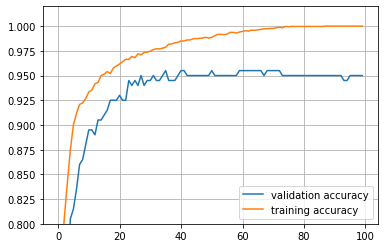

In [16]:
plt.plot( history.history['val_binary_accuracy'], label='validation accuracy')
plt.plot( history.history['binary_accuracy'], label = 'training accuracy')
plt.ylim([0.8, 1.02])
plt.grid()
plt.legend()
plt.show()

In [17]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

epochs = 5
model.fit(x = x_train, y = y_train, epochs=epochs, validation_data = (x_test, y_test))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 1664)              12642880  
                                                                 
 flatten (Flatten)           (None, 1664)              0         
                                                                 
 dense (Dense)               (None, 100)               166500    
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101   

2022-08-15 21:30:42.728312: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 360120000 exceeds 10% of free system memory.
2022-08-15 21:30:43.156635: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 360120000 exceeds 10% of free system memory.


Epoch 1/5


2022-08-15 21:30:55.903094: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-15 21:30:55.904378: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-15 21:30:55.921956: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.82GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-15 21:30:55.922015: W tensorflow/core/common_runtime/bfc_allocato

93/94 [============================>.] - ETA: 0s - loss: 0.0051 - binary_accuracy: 1.0000

2022-08-15 21:31:16.377597: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.84GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-15 21:31:16.380906: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.84GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-15 21:31:18.618870: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-15 21:31:18.618913: W tensorflow/core/common_runtime/bfc_allocato

94/94 [==============================] - 40s 273ms/step - loss: 0.0050 - binary_accuracy: 1.0000 - val_loss: 0.2271 - val_binary_accuracy: 0.9500
Epoch 2/5
94/94 [==============================] - 18s 190ms/step - loss: 0.0018 - binary_accuracy: 1.0000 - val_loss: 0.2198 - val_binary_accuracy: 0.9550
Epoch 3/5
94/94 [==============================] - 18s 189ms/step - loss: 0.0011 - binary_accuracy: 1.0000 - val_loss: 0.2248 - val_binary_accuracy: 0.9550
Epoch 4/5
94/94 [==============================] - 18s 191ms/step - loss: 7.1046e-04 - binary_accuracy: 1.0000 - val_loss: 0.2254 - val_binary_accuracy: 0.9550
Epoch 5/5
94/94 [==============================] - 18s 195ms/step - loss: 5.0295e-04 - binary_accuracy: 1.0000 - val_loss: 0.2305 - val_binary_accuracy: 0.9550
